In [1]:
import numpy as np

import os
import time
import warnings

import pandas as pd
import numpy as np

from keras.layers import RepeatVector
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") # Hide messy Numpy warnings

Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [3]:
sales_data = pd.read_csv("data/tractor-sales.csv")
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data.head(5)

,Tractor-Sales
0,141
1,157
2,185
3,199
4,203


In [4]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [5]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [6]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

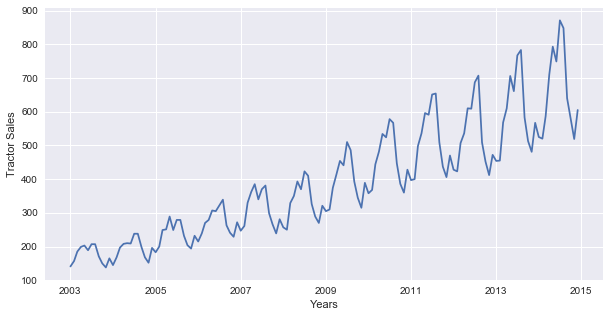

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales');

In [8]:
# convert an array of values into a dataset matrix
def prepare_sequences(dataset, sequence_length=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sequence_length-1):
        dataX.append(dataset[i:(i+sequence_length), 0])
        dataY.append(dataset[i + sequence_length, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# load the dataset
dataset = sales_ts.values
dataset = dataset.astype('float32')

In [10]:
dataset

array([ 141.,  157.,  185.,  199.,  203.,  189.,  207.,  207.,  171.,
        150.,  138.,  165.,  145.,  168.,  197.,  208.,  210.,  209.,
        238.,  238.,  199.,  168.,  152.,  196.,  183.,  200.,  249.,
        251.,  289.,  249.,  279.,  279.,  232.,  204.,  194.,  232.,
        215.,  239.,  270.,  279.,  307.,  305.,  322.,  339.,  263.,
        241.,  229.,  272.,  247.,  261.,  330.,  362.,  385.,  340.,
        370.,  381.,  299.,  266.,  239.,  281.,  257.,  250.,  329.,
        350.,  393.,  370.,  423.,  410.,  326.,  289.,  270.,  321.,
        305.,  310.,  374.,  414.,  454.,  441.,  510.,  486.,  393.,
        345.,  315.,  389.,  358.,  368.,  444.,  482.,  534.,  524.,
        578.,  567.,  447.,  386.,  360.,  428.,  397.,  400.,  498.,
        536.,  596.,  591.,  651.,  654.,  509.,  437.,  406.,  470.,
        428.,  423.,  507.,  536.,  610.,  609.,  687.,  707.,  509.,
        452.,  412.,  472.,  454.,  455.,  568.,  610.,  706.,  661.,
        767.,  783.,

In [11]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [12]:
# split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size

In [13]:
train_size

108

In [14]:
test_size

36

In [15]:
test_size + train_size

144

In [16]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [17]:
# Define sequence length for the samples
sequence_length = 3

In [18]:
# reshape into X=t and Y=t+1
trainX, trainY = prepare_sequences(train, sequence_length)
testX, testY = prepare_sequences(test, sequence_length)

In [19]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [20]:
# create the LSTM network
def model1():
    model = Sequential()
    model.add(LSTM(units=4, input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    return model

In [21]:
# create the LSTM network
def model2():
    model = Sequential()

    model.add(LSTM(units=50, input_shape=(looksequence_length_back, 1), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation("linear"))
    return model

In [22]:
model = model1()

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
104/104 [==============================] - 1s - loss: 0.0543     
Epoch 2/100
104/104 [==============================] - 1s - loss: 0.0198     
Epoch 3/100
104/104 [==============================] - 0s - loss: 0.0155     
Epoch 4/100
104/104 [==============================] - 0s - loss: 0.0127     
Epoch 5/100
104/104 [==============================] - 0s - loss: 0.0108     
Epoch 6/100
104/104 [==============================] - 0s - loss: 0.0093     
Epoch 7/100
104/104 [==============================] - 0s - loss: 0.0080     
Epoch 8/100
104/104 [==============================] - 0s - loss: 0.0072     
Epoch 9/100
104/104 [==============================] - 0s - loss: 0.0069     
Epoch 10/100
104/104 [==============================] - 0s - loss: 0.0066     
Epoch 11/100
104/104 [==============================] - 0s - loss: 0.0066     
Epoch 12/100
104/104 [==============================] - 0s - loss: 0.0065     
Epoch 13/100
104/104 [==============================] - 0s - 

In [24]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [25]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [26]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 45.59 RMSE


In [27]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 94.29 RMSE


In [28]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[sequence_length : sequence_length + len(trainPredict), :] = trainPredict

In [29]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[sequence_length + len(trainPredict) + sequence_length + 1: len(dataset) - 1, :] = testPredict

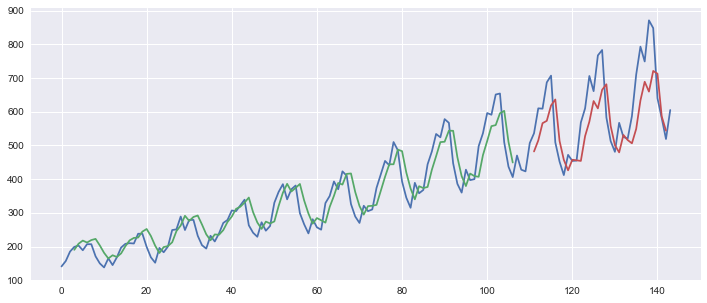

In [30]:
# plot baseline and predictions
plt.figure(figsize=(12, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Forecasting

Start with the entire dataset and predict. Then shift the window by 1 popping out first point from the dataset and adding the last prediction as a new data point at the end in the window. Use the new dataset to predict.

In [31]:
dataset = sales_ts.values
dataset = dataset.astype('float32')

In [32]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [33]:
forecast_window = 12

In [34]:
preds= []

for i in range(forecast_window):
    dataX = []
    for i in range(len(dataset) - sequence_length + 1):
        a = dataset[i:(i+sequence_length), 0]
        dataX.append(a)
    dataX = np.array(dataX)
    # reshape input to be [samples, time steps, features]
    dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[1], 1))
    dataXpred = model.predict(dataX)
    preds.append(dataXpred[-1])
    dataset = dataset[1:]
    dataset = np.insert(dataset, [len(dataset)], np.reshape(preds[-1], (-1, 1)), axis=0)

In [35]:
preds

[array([ 0.57472074], dtype=float32),
 array([ 0.55065125], dtype=float32),
 array([ 0.52562726], dtype=float32),
 array([ 0.50826269], dtype=float32),
 array([ 0.49427256], dtype=float32),
 array([ 0.4831548], dtype=float32),
 array([ 0.47408503], dtype=float32),
 array([ 0.46661404], dtype=float32),
 array([ 0.46039823], dtype=float32),
 array([ 0.4551886], dtype=float32),
 array([ 0.45079595], dtype=float32),
 array([ 0.44707397], dtype=float32)]

In [36]:
actual = np.empty(shape=(len(dataset) + forecast_window, 1))
actual[:, :] = np.nan

In [37]:
forecasts = np.empty_like(actual)
forecasts[:, :] = np.nan

In [38]:
dataset = sales_ts.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [39]:
actual[0:len(dataset),:] = dataset

In [40]:
forecasts[len(dataset):] = np.reshape(preds, (forecast_window, 1))

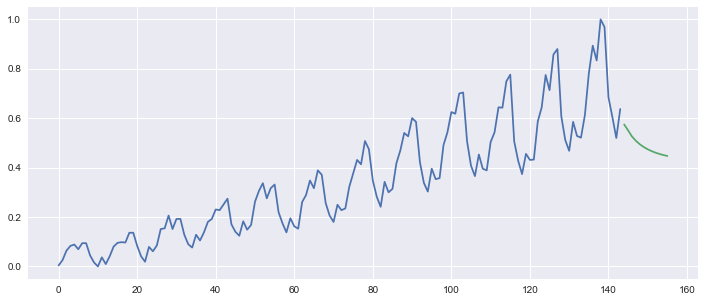

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(actual)
plt.plot(forecasts);

**Observation**
> The LSTM did not learn any pattern at all